In [1]:
from copy import deepcopy

from tqdm import tqdm
import numpy as np
from scipy.special import softmax
import gym
from gym.envs.toy_text import BlackjackEnv
import matplotlib.pyplot as plt

from double_blackjack import DoubleBJ
from count_double_blackjack import CountDBJ
from double_sc_blackjack import SplitCountDBJ

In [2]:
np.random.seed(0)

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [3]:
# Простая функция реализующая стратегию выше
def simple_run(num_episodes):
    env = gym.make('Blackjack-v1')
    rewards = []
    for i_episode in range(num_episodes):
        observation = env.reset()
        for t in range(100):
            obs = observation[0]
            action = 1 if 18 > obs and obs < 22 else 0
            observation, reward, done, info = env.step(action)
            if done:
                rewards.append(reward)
                break
    env.close()
    return np.mean(rewards)

###### Сыграем 100 000 эпизодов по этой стратегии и посчитаем средний выигрыш:

In [4]:
f"Средний выигрыш (проигрыш) по наивной стратегии: {simple_run(10 ** 5)}"

'Средний выигрыш (проигрыш) по наивной стратегии: -0.11414'

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [6]:
# загрузим классы для обучения, у меня они получились объемные, поэтому реализовал в отдельном файле

from q_learn import Q_learn
from monte_carlo_control import MC_learn

In [7]:
def iterate(model, num_iter=100, n_iter=10**5):
    mean_rewards = []
    mean_val_rewards = []
    max_rew = -1.0
    best_state = None
    for _ in tqdm(range(num_iter)):
        train_r = model.train(n_iter)
        eval_r = model.eval(n_iter)
        if eval_r > max_rew:
            max_rew = eval_r
            best_state = model.get_state_dict()
        mean_rewards.append(train_r)
        mean_val_rewards.append(eval_r)
        print(f"Train reward: {train_r}, val reward: {eval_r}, max: {max_rew}")
    model.load_state_dict(best_state)
    return mean_rewards, mean_val_rewards

In [7]:
# Обучим методом Q-learning
alpha = 0.01
gamma = 0.1
eps = 0.01
num_iter = 100
model = Q_learn(BlackjackEnv, alpha, gamma, eps)

mean_rewards1, mean_val_rewards1 = iterate(model, num_iter=num_iter)

100%|██████████| 100/100 [29:40<00:00, 17.81s/it]


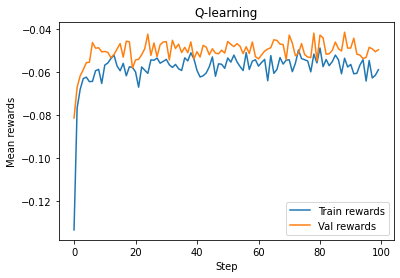

In [8]:
plt.plot(list(range(num_iter)), mean_rewards1, label="Train rewards")
plt.plot(list(range(num_iter)), mean_val_rewards1, label="Val rewards")
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("Q-learning")
plt.legend()

In [9]:
f"Максимальный средний выигрыш при обучении методом Q-learning: {np.max(mean_val_rewards1)}"

'Максимальный средний выигрыш при обучении методом Q-learning: -0.04146'

In [10]:
# Обучим методом off-policy Monte Carlo control
num_iter = 100
gamma = 1.0
eps = 0.01
off_policy = True
model = MC_learn(BlackjackEnv, gamma, eps, off_policy)
mean_rewards2, mean_val_rewards2 = iterate(model, num_iter=num_iter)

100%|██████████| 100/100 [29:59<00:00, 17.99s/it]


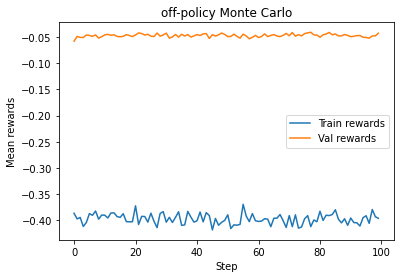

In [11]:
plt.plot(list(range(num_iter)), mean_rewards2, label="Train rewards")
plt.plot(list(range(num_iter)), mean_val_rewards2, label="Val rewards")
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("off-policy Monte Carlo")
plt.legend()

Так как behavior стратегия случайная, train rewards низкие.
Нарисуем средние награды на валидации

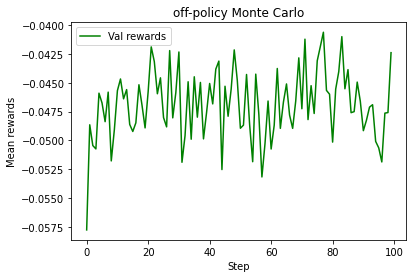

In [12]:
plt.plot(list(range(num_iter)), mean_val_rewards2, label="Val rewards", color='g')
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("off-policy Monte Carlo")
plt.legend()

In [13]:
f"Максимальный средний выигрыш при обучении методом off-policy Monte Carlo: {np.max(mean_val_rewards2)}"

'Максимальный средний выигрыш при обучении методом off-policy Monte Carlo: -0.04062'

In [14]:
# Теперь обучим методом on-policy Monte Carlo control
num_iter = 100
gamma = 1.0
eps = 0.01
off_policy = False
model = MC_learn(BlackjackEnv, gamma, eps, off_policy)
mean_rewards3, mean_val_rewards3 = iterate(model, num_iter=num_iter)

100%|██████████| 100/100 [31:47<00:00, 19.07s/it]


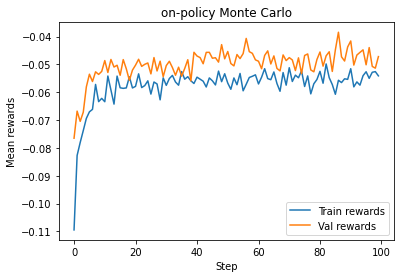

In [15]:
plt.plot(list(range(num_iter)), mean_rewards3, label="Train rewards")
plt.plot(list(range(num_iter)), mean_val_rewards3, label="Val rewards")
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("on-policy Monte Carlo")
plt.legend()

In [16]:
f"Максимальный средний выигрыш при обучении методом on-policy Monte Carlo: {np.max(mean_val_rewards3)}"

'Максимальный средний выигрыш при обучении методом on-policy Monte Carlo: -0.03847'

Дальше буду обучать только по off-policy Monte Carlo, так как результаты, полученные этим алгоритмом в среднем получились чуть лучше других

#### Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

Реализация в файле double_blackjack.py, class DoubleBJ

#### Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [17]:
num_iter = 200
gamma = 1.0
eps = 0.01
off_policy = True
model = MC_learn(DoubleBJ, gamma, eps, off_policy)
mean_rewards4, mean_val_rewards4 = iterate(model, num_iter=num_iter)

100%|██████████| 200/200 [59:09<00:00, 17.75s/it]


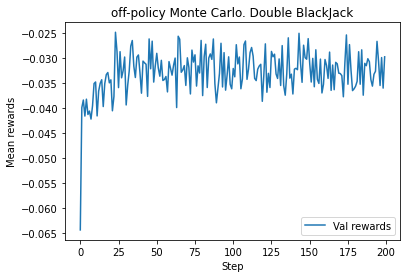

In [18]:
plt.plot(list(range(num_iter)), mean_val_rewards4, label="Val rewards")
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("off-policy Monte Carlo. Double BlackJack")
plt.legend()

In [19]:
f"Максимальный средний выигрыш для DoubleBlackJack: {np.max(mean_val_rewards4)}. Улучшение с {np.max(mean_val_rewards2)} до {np.max(mean_val_rewards4)}"

'Максимальный средний выигрыш для DoubleBlackJack: -0.02475. Улучшение с -0.04062 до -0.02475'

#### Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

Реализация в файле count_double_blackjack, class CountDBJ

#### Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [10]:
num_iter = 1000
gamma = 1.0
eps = 0.01
off_policy = True
model = MC_learn(CountDBJ, gamma, eps, off_policy)
mean_rewards5, mean_val_rewards5 = iterate(model, num_iter=num_iter)

100%|██████████| 1000/1000 [1:56:11<00:00,  6.97s/it]


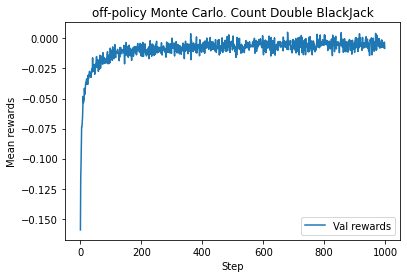

In [11]:
plt.plot(list(range(num_iter)), mean_val_rewards5, label="Val rewards")
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("off-policy Monte Carlo. Count Double BlackJack")
plt.legend()

In [12]:
f"Максимальный средний выигрыш для Count DoubleBlackJack: {np.max(mean_val_rewards5)}"

'Максимальный средний выигрыш для Count DoubleBlackJack: 0.00516'

In [ ]:
alpha = 0.01
gamma = 0.01
eps = 0.01
num_iter = 100
model = Q_learn(SplitCountDBJ, alpha, gamma, eps)

mean_rewards6, mean_val_rewards6 = iterate(model, num_iter=num_iter, n_iter=5 * 10 ** 5)

  1%|          | 1/100 [00:36<59:54, 36.31s/it]

Train reward: -0.166078, val reward: -0.087266, max: -0.087266


  2%|▏         | 2/100 [01:12<59:02, 36.15s/it]

Train reward: -0.085696, val reward: -0.069994, max: -0.069994


  3%|▎         | 3/100 [01:49<58:54, 36.43s/it]

Train reward: -0.068028, val reward: -0.059038, max: -0.059038


  4%|▍         | 4/100 [02:26<59:02, 36.90s/it]

Train reward: -0.064778, val reward: -0.049886, max: -0.049886


  5%|▌         | 5/100 [03:04<58:57, 37.23s/it]

Train reward: -0.05536, val reward: -0.0426, max: -0.0426


  6%|▌         | 6/100 [03:42<58:57, 37.63s/it]

Train reward: -0.05283, val reward: -0.043902, max: -0.0426


  7%|▋         | 7/100 [04:20<58:20, 37.64s/it]

Train reward: -0.050028, val reward: -0.043556, max: -0.0426


  8%|▊         | 8/100 [04:58<57:48, 37.70s/it]

Train reward: -0.049012, val reward: -0.04092, max: -0.04092


  9%|▉         | 9/100 [05:34<56:10, 37.04s/it]

Train reward: -0.05048, val reward: -0.03735, max: -0.03735


 10%|█         | 10/100 [06:12<56:12, 37.48s/it]

Train reward: -0.048154, val reward: -0.03852, max: -0.03735


 11%|█         | 11/100 [06:51<56:14, 37.91s/it]

Train reward: -0.044656, val reward: -0.037682, max: -0.03735


 12%|█▏        | 12/100 [07:26<54:30, 37.17s/it]

Train reward: -0.04496, val reward: -0.040174, max: -0.03735


 13%|█▎        | 13/100 [08:02<53:20, 36.79s/it]

Train reward: -0.041552, val reward: -0.034498, max: -0.034498


 14%|█▍        | 14/100 [08:38<52:29, 36.62s/it]

Train reward: -0.04123, val reward: -0.034754, max: -0.034498


 15%|█▌        | 15/100 [09:15<51:45, 36.53s/it]

Train reward: -0.042856, val reward: -0.03374, max: -0.03374


 16%|█▌        | 16/100 [09:54<52:17, 37.35s/it]

Train reward: -0.041406, val reward: -0.032266, max: -0.032266


 17%|█▋        | 17/100 [10:34<52:31, 37.97s/it]

Train reward: -0.041812, val reward: -0.0349, max: -0.032266


 18%|█▊        | 18/100 [11:11<51:33, 37.72s/it]

Train reward: -0.041288, val reward: -0.035658, max: -0.032266


 19%|█▉        | 19/100 [11:48<50:52, 37.68s/it]

Train reward: -0.041122, val reward: -0.032222, max: -0.032222


 20%|██        | 20/100 [12:25<49:56, 37.46s/it]

Train reward: -0.04203, val reward: -0.030766, max: -0.030766


 21%|██        | 21/100 [13:01<48:47, 37.05s/it]

Train reward: -0.04079, val reward: -0.033542, max: -0.030766


 22%|██▏       | 22/100 [13:37<47:38, 36.64s/it]

Train reward: -0.042192, val reward: -0.032232, max: -0.030766


 23%|██▎       | 23/100 [14:13<46:46, 36.45s/it]

Train reward: -0.040524, val reward: -0.03537, max: -0.030766


 24%|██▍       | 24/100 [14:50<46:21, 36.60s/it]

Train reward: -0.04292, val reward: -0.031456, max: -0.030766


 25%|██▌       | 25/100 [15:26<45:43, 36.58s/it]

Train reward: -0.039426, val reward: -0.030114, max: -0.030114


 26%|██▌       | 26/100 [16:03<44:57, 36.46s/it]

Train reward: -0.037962, val reward: -0.032244, max: -0.030114


 27%|██▋       | 27/100 [16:38<44:07, 36.27s/it]

Train reward: -0.04099, val reward: -0.033246, max: -0.030114


 28%|██▊       | 28/100 [17:14<43:15, 36.04s/it]

Train reward: -0.039866, val reward: -0.033834, max: -0.030114


 29%|██▉       | 29/100 [17:50<42:38, 36.04s/it]

Train reward: -0.03927, val reward: -0.031632, max: -0.030114


 30%|███       | 30/100 [18:26<42:08, 36.13s/it]

Train reward: -0.038384, val reward: -0.027562, max: -0.027562


 31%|███       | 31/100 [19:03<41:42, 36.26s/it]

Train reward: -0.036482, val reward: -0.029834, max: -0.027562


 32%|███▏      | 32/100 [19:39<40:58, 36.16s/it]

Train reward: -0.039974, val reward: -0.029604, max: -0.027562


 33%|███▎      | 33/100 [20:15<40:22, 36.16s/it]

Train reward: -0.039436, val reward: -0.030592, max: -0.027562


 34%|███▍      | 34/100 [20:51<39:50, 36.22s/it]

Train reward: -0.038942, val reward: -0.032734, max: -0.027562


 35%|███▌      | 35/100 [21:27<39:01, 36.02s/it]

Train reward: -0.038608, val reward: -0.03014, max: -0.027562


 36%|███▌      | 36/100 [22:03<38:30, 36.10s/it]

Train reward: -0.040012, val reward: -0.032694, max: -0.027562


 37%|███▋      | 37/100 [22:40<38:06, 36.29s/it]

Train reward: -0.040292, val reward: -0.031402, max: -0.027562


 38%|███▊      | 38/100 [23:16<37:19, 36.13s/it]

Train reward: -0.037718, val reward: -0.032566, max: -0.027562


 39%|███▉      | 39/100 [23:51<36:36, 36.01s/it]

Train reward: -0.042922, val reward: -0.030986, max: -0.027562


 40%|████      | 40/100 [24:27<35:56, 35.94s/it]

Train reward: -0.042486, val reward: -0.03062, max: -0.027562


 41%|████      | 41/100 [25:03<35:22, 35.97s/it]

Train reward: -0.04068, val reward: -0.031016, max: -0.027562


 42%|████▏     | 42/100 [25:40<34:53, 36.09s/it]

Train reward: -0.042914, val reward: -0.033762, max: -0.027562


 43%|████▎     | 43/100 [26:16<34:26, 36.25s/it]

Train reward: -0.039192, val reward: -0.030658, max: -0.027562


 44%|████▍     | 44/100 [26:55<34:35, 37.06s/it]

Train reward: -0.041694, val reward: -0.03392, max: -0.027562


 45%|████▌     | 45/100 [27:31<33:39, 36.73s/it]

Train reward: -0.04006, val reward: -0.03242, max: -0.027562


 46%|████▌     | 46/100 [28:07<32:51, 36.50s/it]

Train reward: -0.04086, val reward: -0.031226, max: -0.027562


 47%|████▋     | 47/100 [28:43<32:01, 36.25s/it]

Train reward: -0.037102, val reward: -0.032966, max: -0.027562


 48%|████▊     | 48/100 [29:18<31:14, 36.04s/it]

Train reward: -0.03998, val reward: -0.032562, max: -0.027562


 49%|████▉     | 49/100 [29:54<30:26, 35.81s/it]

Train reward: -0.038556, val reward: -0.030814, max: -0.027562


 50%|█████     | 50/100 [30:29<29:43, 35.68s/it]

Train reward: -0.041956, val reward: -0.032082, max: -0.027562


 51%|█████     | 51/100 [31:04<29:03, 35.59s/it]

Train reward: -0.04054, val reward: -0.031054, max: -0.027562


 52%|█████▏    | 52/100 [31:40<28:23, 35.49s/it]

Train reward: -0.041252, val reward: -0.030004, max: -0.027562


 53%|█████▎    | 53/100 [32:15<27:54, 35.62s/it]

Train reward: -0.04058, val reward: -0.029836, max: -0.027562


 54%|█████▍    | 54/100 [32:51<27:18, 35.61s/it]

Train reward: -0.039766, val reward: -0.031334, max: -0.027562


 55%|█████▌    | 55/100 [33:26<26:38, 35.53s/it]

Train reward: -0.04033, val reward: -0.029022, max: -0.027562


 56%|█████▌    | 56/100 [34:02<26:03, 35.54s/it]

Train reward: -0.040468, val reward: -0.03164, max: -0.027562


 57%|█████▋    | 57/100 [34:37<25:26, 35.51s/it]

Train reward: -0.03938, val reward: -0.033886, max: -0.027562


 58%|█████▊    | 58/100 [35:13<24:52, 35.54s/it]

Train reward: -0.0427, val reward: -0.03149, max: -0.027562


 59%|█████▉    | 59/100 [35:48<24:15, 35.51s/it]

Train reward: -0.043048, val reward: -0.03028, max: -0.027562


 60%|██████    | 60/100 [36:24<23:46, 35.66s/it]

Train reward: -0.0419, val reward: -0.028864, max: -0.027562


 61%|██████    | 61/100 [37:00<23:08, 35.61s/it]

Train reward: -0.03996, val reward: -0.034368, max: -0.027562


 62%|██████▏   | 62/100 [37:36<22:34, 35.63s/it]

Train reward: -0.041034, val reward: -0.031642, max: -0.027562


 63%|██████▎   | 63/100 [38:11<21:54, 35.52s/it]

Train reward: -0.039056, val reward: -0.030372, max: -0.027562


 64%|██████▍   | 64/100 [38:47<21:28, 35.80s/it]

Train reward: -0.040184, val reward: -0.030414, max: -0.027562


 65%|██████▌   | 65/100 [39:23<20:48, 35.66s/it]

Train reward: -0.04054, val reward: -0.029644, max: -0.027562


 66%|██████▌   | 66/100 [39:58<20:13, 35.68s/it]

Train reward: -0.042408, val reward: -0.031818, max: -0.027562


 67%|██████▋   | 67/100 [40:34<19:40, 35.77s/it]

Train reward: -0.040536, val reward: -0.029988, max: -0.027562


 68%|██████▊   | 68/100 [41:11<19:13, 36.06s/it]

Train reward: -0.040212, val reward: -0.031848, max: -0.027562


 69%|██████▉   | 69/100 [41:47<18:34, 35.97s/it]

Train reward: -0.042016, val reward: -0.032576, max: -0.027562


 70%|███████   | 70/100 [42:23<17:58, 35.94s/it]

Train reward: -0.03961, val reward: -0.02945, max: -0.027562


 71%|███████   | 71/100 [42:59<17:25, 36.05s/it]

Train reward: -0.040556, val reward: -0.030276, max: -0.027562


 72%|███████▏  | 72/100 [43:35<16:47, 35.97s/it]

Train reward: -0.040372, val reward: -0.033366, max: -0.027562


 73%|███████▎  | 73/100 [44:10<16:07, 35.84s/it]

Train reward: -0.039722, val reward: -0.028704, max: -0.027562


 74%|███████▍  | 74/100 [44:46<15:28, 35.71s/it]

Train reward: -0.042804, val reward: -0.030312, max: -0.027562


 75%|███████▌  | 75/100 [45:21<14:51, 35.65s/it]

Train reward: -0.037618, val reward: -0.030032, max: -0.027562


 76%|███████▌  | 76/100 [45:57<14:13, 35.56s/it]

Train reward: -0.040606, val reward: -0.030644, max: -0.027562


 77%|███████▋  | 77/100 [46:32<13:38, 35.60s/it]

Train reward: -0.040706, val reward: -0.032762, max: -0.027562


 78%|███████▊  | 78/100 [47:09<13:07, 35.82s/it]

Train reward: -0.039182, val reward: -0.029668, max: -0.027562


 79%|███████▉  | 79/100 [47:44<12:31, 35.78s/it]

Train reward: -0.038056, val reward: -0.029634, max: -0.027562


 80%|████████  | 80/100 [48:20<11:56, 35.80s/it]

Train reward: -0.03863, val reward: -0.032334, max: -0.027562


 81%|████████  | 81/100 [48:56<11:19, 35.76s/it]

Train reward: -0.0391, val reward: -0.028656, max: -0.027562


 82%|████████▏ | 82/100 [49:32<10:43, 35.75s/it]

Train reward: -0.040062, val reward: -0.029708, max: -0.027562


 83%|████████▎ | 83/100 [50:07<10:08, 35.77s/it]

Train reward: -0.042346, val reward: -0.03073, max: -0.027562


 84%|████████▍ | 84/100 [50:44<09:35, 35.94s/it]

Train reward: -0.040224, val reward: -0.031228, max: -0.027562


 85%|████████▌ | 85/100 [51:20<09:00, 36.01s/it]

Train reward: -0.037834, val reward: -0.033198, max: -0.027562


 86%|████████▌ | 86/100 [51:56<08:25, 36.10s/it]

Train reward: -0.040042, val reward: -0.029814, max: -0.027562


 87%|████████▋ | 87/100 [52:32<07:49, 36.09s/it]

Train reward: -0.040026, val reward: -0.031412, max: -0.027562


 88%|████████▊ | 88/100 [53:09<07:13, 36.14s/it]

Train reward: -0.042502, val reward: -0.032454, max: -0.027562


 89%|████████▉ | 89/100 [53:44<06:35, 35.94s/it]

Train reward: -0.043666, val reward: -0.030206, max: -0.027562


 90%|█████████ | 90/100 [54:20<05:59, 35.95s/it]

Train reward: -0.03834, val reward: -0.029916, max: -0.027562


 91%|█████████ | 91/100 [54:56<05:24, 36.01s/it]

Train reward: -0.040876, val reward: -0.031986, max: -0.027562


 92%|█████████▏| 92/100 [55:32<04:47, 35.91s/it]

Train reward: -0.044364, val reward: -0.030822, max: -0.027562


 93%|█████████▎| 93/100 [56:07<04:10, 35.82s/it]

Train reward: -0.03935, val reward: -0.029676, max: -0.027562


 94%|█████████▍| 94/100 [56:43<03:35, 35.88s/it]

Train reward: -0.03821, val reward: -0.029772, max: -0.027562


 95%|█████████▌| 95/100 [57:19<02:59, 35.80s/it]

Train reward: -0.038612, val reward: -0.029962, max: -0.027562


 96%|█████████▌| 96/100 [57:55<02:23, 35.75s/it]

Train reward: -0.036146, val reward: -0.028512, max: -0.027562


 97%|█████████▋| 97/100 [58:30<01:46, 35.59s/it]

Train reward: -0.039738, val reward: -0.032004, max: -0.027562


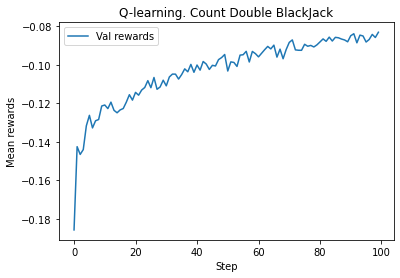

In [10]:
# plt.plot(list(range(num_iter)), mean_rewards6, label="Train rewards")
plt.plot(list(range(num_iter)), mean_val_rewards6, label="Val rewards")
plt.xlabel("Step")
plt.ylabel("Mean rewards")
plt.title("Q-learning. Count Double BlackJack")
plt.legend()

Обыграть казино так и не удалось, но улучшения после каждого нового пункта были. Также удалось реализовать 3 алгоритма обучения и сравнить их: q-learning, off-policy Monte-Carlo control и on-policy Monte-Carlo control

In [11]:
np.max(mean_val_rewards6)

-0.083094

In [ ]:
num_iter = 100
gamma = 1.0
eps = 0.1
off_policy = False
# model = MC_learn(SplitCountDBJ, gamma, eps, off_policy)
mean_rewards3, mean_val_rewards3 = iterate(model, num_iter=num_iter)

  1%|          | 1/100 [00:12<21:01, 12.74s/it]

Train reward: -0.04053, val reward: -0.03816, max: -0.03816


  2%|▏         | 2/100 [00:25<20:29, 12.55s/it]

Train reward: -0.04198, val reward: -0.03522, max: -0.03522


  3%|▎         | 3/100 [00:37<20:12, 12.50s/it]

Train reward: -0.04, val reward: -0.02921, max: -0.02921


  4%|▍         | 4/100 [00:50<19:58, 12.49s/it]

Train reward: -0.03511, val reward: -0.03529, max: -0.03529


  5%|▌         | 5/100 [01:02<19:54, 12.57s/it]

Train reward: -0.03776, val reward: -0.0354, max: -0.0354


  6%|▌         | 6/100 [01:15<19:36, 12.52s/it]

Train reward: -0.04049, val reward: -0.03444, max: -0.03444


  7%|▋         | 7/100 [01:27<19:20, 12.48s/it]

Train reward: -0.04312, val reward: -0.03659, max: -0.03659


  8%|▊         | 8/100 [01:40<19:07, 12.48s/it]

Train reward: -0.04315, val reward: -0.03926, max: -0.03926


  9%|▉         | 9/100 [01:53<19:27, 12.83s/it]

Train reward: -0.03632, val reward: -0.03412, max: -0.03412


 10%|█         | 10/100 [02:09<20:34, 13.72s/it]

Train reward: -0.04008, val reward: -0.03679, max: -0.03679


 11%|█         | 11/100 [02:22<20:02, 13.52s/it]

Train reward: -0.03362, val reward: -0.03881, max: -0.03881


 12%|█▏        | 12/100 [02:34<19:21, 13.20s/it]

Train reward: -0.03915, val reward: -0.03479, max: -0.03479


 13%|█▎        | 13/100 [02:47<18:50, 13.00s/it]

Train reward: -0.04306, val reward: -0.03323, max: -0.03323


 14%|█▍        | 14/100 [03:00<18:29, 12.91s/it]

Train reward: -0.0402, val reward: -0.04089, max: -0.04089


 15%|█▌        | 15/100 [03:13<18:22, 12.97s/it]

Train reward: -0.04249, val reward: -0.03777, max: -0.03777


 16%|█▌        | 16/100 [03:26<18:11, 12.99s/it]

Train reward: -0.03856, val reward: -0.03626, max: -0.03626


 17%|█▋        | 17/100 [03:39<17:51, 12.90s/it]

Train reward: -0.03678, val reward: -0.03485, max: -0.03485


 18%|█▊        | 18/100 [03:52<17:40, 12.93s/it]

Train reward: -0.0466, val reward: -0.03597, max: -0.03597


 19%|█▉        | 19/100 [04:04<17:23, 12.89s/it]

Train reward: -0.04362, val reward: -0.04298, max: -0.04298


 20%|██        | 20/100 [04:17<17:07, 12.84s/it]

Train reward: -0.03747, val reward: -0.03806, max: -0.03806


 21%|██        | 21/100 [04:30<16:50, 12.79s/it]

Train reward: -0.03941, val reward: -0.04254, max: -0.04254


 22%|██▏       | 22/100 [04:43<16:39, 12.82s/it]

Train reward: -0.03373, val reward: -0.03269, max: -0.03269


 23%|██▎       | 23/100 [04:55<16:25, 12.80s/it]

Train reward: -0.04078, val reward: -0.0342, max: -0.0342


 24%|██▍       | 24/100 [05:08<16:10, 12.77s/it]

Train reward: -0.03981, val reward: -0.03299, max: -0.03299


 25%|██▌       | 25/100 [05:21<15:59, 12.79s/it]

Train reward: -0.04258, val reward: -0.03178, max: -0.03178


 26%|██▌       | 26/100 [05:34<15:46, 12.78s/it]

Train reward: -0.03871, val reward: -0.03418, max: -0.03418


 27%|██▋       | 27/100 [05:46<15:30, 12.75s/it]

Train reward: -0.03725, val reward: -0.04376, max: -0.04376


 28%|██▊       | 28/100 [05:59<15:18, 12.75s/it]

Train reward: -0.04289, val reward: -0.03334, max: -0.03334


 29%|██▉       | 29/100 [06:12<15:15, 12.90s/it]

Train reward: -0.03749, val reward: -0.03616, max: -0.03616


 30%|███       | 30/100 [06:26<15:12, 13.03s/it]

Train reward: -0.03944, val reward: -0.03336, max: -0.03336


 31%|███       | 31/100 [06:38<14:53, 12.94s/it]

Train reward: -0.04401, val reward: -0.03066, max: -0.03066


 32%|███▏      | 32/100 [06:51<14:41, 12.97s/it]

Train reward: -0.04042, val reward: -0.03642, max: -0.03642


 33%|███▎      | 33/100 [07:04<14:25, 12.92s/it]

Train reward: -0.03982, val reward: -0.03428, max: -0.03428


 34%|███▍      | 34/100 [07:17<14:08, 12.85s/it]

Train reward: -0.03889, val reward: -0.03557, max: -0.03557


 35%|███▌      | 35/100 [07:30<13:51, 12.79s/it]

Train reward: -0.04652, val reward: -0.03713, max: -0.03713


 36%|███▌      | 36/100 [07:42<13:39, 12.81s/it]

Train reward: -0.04258, val reward: -0.02893, max: -0.02893


 37%|███▋      | 37/100 [07:55<13:27, 12.82s/it]

Train reward: -0.04184, val reward: -0.03515, max: -0.03515


 38%|███▊      | 38/100 [08:09<13:32, 13.11s/it]

Train reward: -0.03801, val reward: -0.03401, max: -0.03401


 39%|███▉      | 39/100 [08:22<13:17, 13.07s/it]

Train reward: -0.03921, val reward: -0.03523, max: -0.03523


 40%|████      | 40/100 [08:36<13:22, 13.38s/it]

Train reward: -0.03452, val reward: -0.03384, max: -0.03384


 41%|████      | 41/100 [08:49<12:59, 13.21s/it]

Train reward: -0.03845, val reward: -0.04063, max: -0.04063


 42%|████▏     | 42/100 [09:02<12:35, 13.03s/it]

Train reward: -0.04149, val reward: -0.03872, max: -0.03872


 43%|████▎     | 43/100 [09:15<12:32, 13.20s/it]

Train reward: -0.04204, val reward: -0.035, max: -0.035


 44%|████▍     | 44/100 [09:28<12:20, 13.23s/it]

Train reward: -0.04041, val reward: -0.02957, max: -0.02957


 45%|████▌     | 45/100 [09:41<12:04, 13.17s/it]

Train reward: -0.03835, val reward: -0.03671, max: -0.03671


 46%|████▌     | 46/100 [09:54<11:42, 13.01s/it]

Train reward: -0.0432, val reward: -0.03207, max: -0.03207


 47%|████▋     | 47/100 [10:08<11:38, 13.18s/it]

Train reward: -0.04381, val reward: -0.02933, max: -0.02933


 48%|████▊     | 48/100 [10:21<11:27, 13.21s/it]

Train reward: -0.04408, val reward: -0.0325, max: -0.0325


 49%|████▉     | 49/100 [10:34<11:10, 13.15s/it]

Train reward: -0.04399, val reward: -0.03498, max: -0.03498


 50%|█████     | 50/100 [10:47<11:01, 13.22s/it]

Train reward: -0.04159, val reward: -0.03145, max: -0.03145


 51%|█████     | 51/100 [11:00<10:36, 12.99s/it]

Train reward: -0.04281, val reward: -0.02907, max: -0.02907


 52%|█████▏    | 52/100 [11:12<10:16, 12.85s/it]

Train reward: -0.03955, val reward: -0.03471, max: -0.03471


 53%|█████▎    | 53/100 [11:25<10:01, 12.80s/it]

Train reward: -0.03974, val reward: -0.03477, max: -0.03477


 54%|█████▍    | 54/100 [11:39<09:58, 13.02s/it]

Train reward: -0.03156, val reward: -0.0337, max: -0.0337


 55%|█████▌    | 55/100 [11:53<10:01, 13.36s/it]

Train reward: -0.04376, val reward: -0.03437, max: -0.03437


 56%|█████▌    | 56/100 [12:06<09:42, 13.25s/it]

Train reward: -0.03781, val reward: -0.03326, max: -0.03326


 57%|█████▋    | 57/100 [12:19<09:28, 13.22s/it]

Train reward: -0.03666, val reward: -0.03384, max: -0.03384


 58%|█████▊    | 58/100 [12:33<09:32, 13.63s/it]

Train reward: -0.04225, val reward: -0.0288, max: -0.0288


 59%|█████▉    | 59/100 [12:46<09:11, 13.45s/it]

Train reward: -0.04015, val reward: -0.02733, max: -0.02733


 60%|██████    | 60/100 [13:00<08:54, 13.37s/it]

Train reward: -0.03631, val reward: -0.03387, max: -0.03387


 61%|██████    | 61/100 [13:14<08:49, 13.59s/it]

Train reward: -0.04012, val reward: -0.03291, max: -0.03291


 62%|██████▏   | 62/100 [13:27<08:37, 13.62s/it]

Train reward: -0.04359, val reward: -0.03361, max: -0.03361


 63%|██████▎   | 63/100 [13:41<08:25, 13.67s/it]

Train reward: -0.04405, val reward: -0.02568, max: -0.02568


 64%|██████▍   | 64/100 [13:55<08:13, 13.72s/it]

Train reward: -0.03859, val reward: -0.03446, max: -0.03446


 65%|██████▌   | 65/100 [14:09<08:01, 13.74s/it]

Train reward: -0.04243, val reward: -0.03747, max: -0.03747


 66%|██████▌   | 66/100 [14:23<07:47, 13.75s/it]

Train reward: -0.04027, val reward: -0.02668, max: -0.02668


 67%|██████▋   | 67/100 [14:36<07:33, 13.75s/it]

Train reward: -0.03758, val reward: -0.03095, max: -0.03095


 68%|██████▊   | 68/100 [14:50<07:20, 13.75s/it]

Train reward: -0.03663, val reward: -0.02859, max: -0.02859


 69%|██████▉   | 69/100 [15:04<07:05, 13.74s/it]

Train reward: -0.03311, val reward: -0.03512, max: -0.03512


 70%|███████   | 70/100 [15:18<06:53, 13.77s/it]

Train reward: -0.03627, val reward: -0.03876, max: -0.03876


 71%|███████   | 71/100 [15:31<06:39, 13.77s/it]

Train reward: -0.03373, val reward: -0.03994, max: -0.03994


 72%|███████▏  | 72/100 [15:44<06:17, 13.49s/it]

Train reward: -0.03935, val reward: -0.03238, max: -0.03238


 73%|███████▎  | 73/100 [15:58<06:03, 13.46s/it]

Train reward: -0.0428, val reward: -0.0345, max: -0.0345


 74%|███████▍  | 74/100 [16:10<05:42, 13.19s/it]

Train reward: -0.03528, val reward: -0.02691, max: -0.02691


 75%|███████▌  | 75/100 [16:23<05:24, 12.99s/it]

Train reward: -0.03482, val reward: -0.03484, max: -0.03484


 76%|███████▌  | 76/100 [16:35<05:07, 12.83s/it]

Train reward: -0.03907, val reward: -0.03352, max: -0.03352


 77%|███████▋  | 77/100 [16:48<04:52, 12.72s/it]

Train reward: -0.04033, val reward: -0.0341, max: -0.0341


 78%|███████▊  | 78/100 [17:00<04:38, 12.64s/it]

Train reward: -0.04394, val reward: -0.03159, max: -0.03159


 79%|███████▉  | 79/100 [17:13<04:26, 12.69s/it]

Train reward: -0.04365, val reward: -0.03658, max: -0.03658


 80%|████████  | 80/100 [17:26<04:16, 12.84s/it]

Train reward: -0.03917, val reward: -0.03035, max: -0.03035


 81%|████████  | 81/100 [17:40<04:07, 13.01s/it]

Train reward: -0.03965, val reward: -0.03399, max: -0.03399


 82%|████████▏ | 82/100 [17:53<03:54, 13.02s/it]

Train reward: -0.03605, val reward: -0.03926, max: -0.03926


 83%|████████▎ | 83/100 [18:05<03:38, 12.86s/it]

Train reward: -0.03487, val reward: -0.03099, max: -0.03099


 84%|████████▍ | 84/100 [18:18<03:24, 12.80s/it]

Train reward: -0.03296, val reward: -0.0371, max: -0.0371


 85%|████████▌ | 85/100 [18:30<03:10, 12.69s/it]

Train reward: -0.03088, val reward: -0.0278, max: -0.0278


 86%|████████▌ | 86/100 [18:43<02:56, 12.61s/it]

Train reward: -0.02729, val reward: -0.03118, max: -0.03118


 87%|████████▋ | 87/100 [18:55<02:43, 12.57s/it]

Train reward: -0.03358, val reward: -0.03647, max: -0.03647


 88%|████████▊ | 88/100 [19:08<02:30, 12.55s/it]

Train reward: -0.03883, val reward: -0.03376, max: -0.03376


 89%|████████▉ | 89/100 [19:20<02:18, 12.59s/it]

Train reward: -0.03331, val reward: -0.02901, max: -0.02901


 90%|█████████ | 90/100 [19:33<02:05, 12.54s/it]

Train reward: -0.03767, val reward: -0.03233, max: -0.03233


 91%|█████████ | 91/100 [19:45<01:52, 12.51s/it]

Train reward: -0.04388, val reward: -0.02792, max: -0.02792


 92%|█████████▏| 92/100 [19:58<01:40, 12.53s/it]

Train reward: -0.04247, val reward: -0.03433, max: -0.03433


 93%|█████████▎| 93/100 [20:10<01:27, 12.53s/it]

Train reward: -0.04162, val reward: -0.03791, max: -0.03791


 94%|█████████▍| 94/100 [20:23<01:15, 12.53s/it]

Train reward: -0.03838, val reward: -0.03197, max: -0.03197


 95%|█████████▌| 95/100 [20:35<01:02, 12.54s/it]

Train reward: -0.03512, val reward: -0.03228, max: -0.03228


 96%|█████████▌| 96/100 [20:48<00:50, 12.57s/it]

Train reward: -0.04197, val reward: -0.03677, max: -0.03677


In [7]:
np.max(mean_val_rewards3)

-0.1292